In [337]:
import pandas as pd
import numpy as np
import os
import enum
import time
import matplotlib.pyplot as plt
import utils
import json
import seaborn as sns

from tqdm.auto import tqdm, trange

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchio as tio
import monai

import nilearn as nl
import nibabel as nib
import nilearn.plotting as nlplt

from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader, Dataset

from sklearn.model_selection import LeaveOneOut, train_test_split

from datetime import datetime

# from google.colab import drive

torch.manual_seed(7)
torch.set_grad_enabled(False)
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:128"

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [26]:
dfs = {}

for algorithm in ["logreg", "svm", "knn", "mlp", "gauss"]:
    dfs[algorithm] = utils.printTableUniMulti(
        f"../study/stats/results-{algorithm}-loo-filter-Uni-Multi.json",
        score="acc",
        skip_uni=["fechner_corr", "gini_index", "information_gain", "pearson_corr", "su_measure"],
        skip_multi=["CMIM", "IWFS", "JMI", "MIM"],
        add_uni={
            "Man": f"../study/stats/results-{algorithm}-loo-filter-Man-Multi.json",
            "ManKru": f"../study/stats/results-{algorithm}-loo-filter-ManKru-Multi.json"
        }
    )
    print()

                    	CFR 	CIFE 	DCSF 	ICAP 	MRI 	MRMR 	
     f_ratio_measure	0.7143	0.6429	0.7662	0.8117	0.6429	0.7857	
        kendall_corr	0.7403	0.5000	0.7143	0.5000	0.6429	0.5000	
     reliefF_measure	0.5000	0.7662	0.5000	0.6429	0.5000	0.5000	
       spearman_corr	0.5000	0.5000	0.6688	0.5714	0.5000	0.5714	
                 Man	0.8117	0.7403	0.6429	0.7143	0.8117	0.6429	
              ManKru	0.6429	0.7403	0.6429	0.7403	0.7403	0.7662	
                    	CFR 	CIFE 	DCSF 	ICAP 	MRI 	MRMR 	
     f_ratio_measure	0.5000	0.5714	0.5000	0.5714	0.5000	0.5000	
        kendall_corr	0.5000	0.5000	0.5000	0.5000	0.5000	0.5000	
     reliefF_measure	0.5000	0.5000	0.5000	0.5714	0.5000	0.5000	
       spearman_corr	0.5000	0.5000	0.5000	0.5000	0.5000	0.5000	
                 Man	0.5000	0.5000	0.5000	0.5000	0.5000	0.5000	
              ManKru	0.5000	0.5000	0.5000	0.5000	0.5000	0.5000	
                    	CFR 	CIFE 	DCSF 	ICAP 	MRI 	MRMR 	
     f_ratio_measure	0.8117	0.5000	0.5974	0.8636	0.6429	0.7143	


<Axes: >

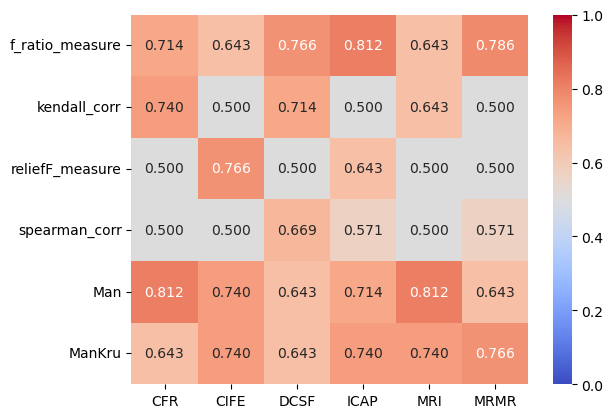

In [28]:
sns.heatmap(dfs["logreg"], annot=True, fmt=".3f", vmin=0, vmax=1, cmap="coolwarm")

In [263]:
study_path = "../study"

info_df = pd.read_csv(f"{study_path}/stats/info.csv").dropna()

subjects = []

for idx, row in info_df.iterrows():
    if "VNSLC" not in row.ID:
        continue
    
    subj_dict = {
        "id": row.ID,
        "resp": row.resp, # Prova cambiando in 0, 0.75, 1
        "age": row.age,
        "sex": row.sex,
        "epilepsy_type": row.epilepsy_type,
        "epilepsy_onset_age": row.epilepsy_onset_age,
        "therapy_duration": row.therapy_duration,
        "AEDs": row.AEDs,
        "FA": tio.ScalarImage(f"{study_path}/subjects/{row.ID}/dMRI/microstructure/dti/{row.ID}_FA.nii.gz"),
        "MD": tio.ScalarImage(f"{study_path}/subjects/{row.ID}/dMRI/microstructure/dti/{row.ID}_MD.nii.gz"),
        "AD": tio.ScalarImage(f"{study_path}/subjects/{row.ID}/dMRI/microstructure/dti/{row.ID}_AD.nii.gz"),
        "RD": tio.ScalarImage(f"{study_path}/subjects/{row.ID}/dMRI/microstructure/dti/{row.ID}_RD.nii.gz"),
        "wFA": tio.ScalarImage(f"{study_path}/subjects/{row.ID}/dMRI/microstructure/diamond/{row.ID}_diamond_wFA.nii.gz"),
        "wMD": tio.ScalarImage(f"{study_path}/subjects/{row.ID}/dMRI/microstructure/diamond/{row.ID}_diamond_wMD.nii.gz"),
        "wAD": tio.ScalarImage(f"{study_path}/subjects/{row.ID}/dMRI/microstructure/diamond/{row.ID}_diamond_wAD.nii.gz"),
        "wRD": tio.ScalarImage(f"{study_path}/subjects/{row.ID}/dMRI/microstructure/diamond/{row.ID}_diamond_wRD.nii.gz"),
        "diamond_frac_csf": tio.ScalarImage(f"{study_path}/subjects/{row.ID}/dMRI/microstructure/diamond/{row.ID}_diamond_frac_csf.nii.gz"),
        "icvf": tio.ScalarImage(f"{study_path}/subjects/{row.ID}/dMRI/microstructure/noddi/{row.ID}_noddi_icvf.nii.gz"),
        "odi": tio.ScalarImage(f"{study_path}/subjects/{row.ID}/dMRI/microstructure/noddi/{row.ID}_noddi_odi.nii.gz"),
        "fextra": tio.ScalarImage(f"{study_path}/subjects/{row.ID}/dMRI/microstructure/noddi/{row.ID}_noddi_fextra.nii.gz"),
        "fiso": tio.ScalarImage(f"{study_path}/subjects/{row.ID}/dMRI/microstructure/noddi/{row.ID}_noddi_fiso.nii.gz"),
        "wfvf": tio.ScalarImage(f"{study_path}/subjects/{row.ID}/dMRI/microstructure/mf/{row.ID}_mf_wfvf.nii.gz"),
        "fvf_tot": tio.ScalarImage(f"{study_path}/subjects/{row.ID}/dMRI/microstructure/mf/{row.ID}_mf_fvf_tot.nii.gz"),
        "mf_frac_csf": tio.ScalarImage(f"{study_path}/subjects/{row.ID}/dMRI/microstructure/mf/{row.ID}_mf_frac_csf.nii.gz"),
        "WM_mask": tio.LabelMap(f"{study_path}/freesurfer/{row.ID}/dlabel/diff/White-Matter++.bbr.nii.gz"),
        "aparc_aseg": tio.LabelMap(f"{study_path}/freesurfer/{row.ID}/dlabel/diff/aparc+aseg+thalnuc.bbr.nii.gz"),
        "t1": tio.ScalarImage(f"{study_path}/subjects/{row.ID}/registration/{row.ID}_T1_brain_reg.nii.gz"),
        # "tract": tio.ScalarImage(f"{study_path}/freesurfer/{row.ID}/dpath/merged_avg16_syn_bbr.mgz")
    }

    subjects.append(tio.Subject(subj_dict))

In [264]:
preprocessing_transform = tio.Compose([
    ## Preprocessing ##
    # Spatial
    tio.transforms.ToCanonical(),
    tio.transforms.Resample("FA"),
    tio.transforms.CopyAffine("FA"),
    tio.transforms.EnsureShapeMultiple(8, method="crop"),
    # Voxel Intensity
    tio.transforms.Mask(masking_method="aparc_aseg"),
    # tio.transforms.RescaleIntensity(percentiles=(0.5, 99.5), masking_method="aparc_aseg"),
    tio.ZNormalization(masking_method=tio.ZNormalization.mean),
])

training_transform = tio.Compose([
    tio.RandomMotion(p=0.2),
    tio.RandomBiasField(p=0.3),
    tio.RandomNoise(p=0.5),
    tio.OneOf({
        tio.RandomAffine(): 0.8,
        tio.RandomElasticDeformation(): 0.2,
    })
])

In [197]:
def looPytorch():
  avg_score = []

  for train_val_idx, test_idx in LeaveOneOut().split(info_df):
    train_val = info_df.iloc[train_val_idx, :]
    test = info_df.iloc[test_idx, :]
    for train_idx, val_idx in LeaveOneOut().split(train_val):
      train = train_val.iloc[train_idx, :]
      val = train_val.iloc[val_idx, :]

      print(train_idx)

      # evaluate the model, fo the hyperParameters selection

    # Select the best model and use it for the test
    # test the model, compute the score and add tot the list

  # mean of avg_score
  return np.mean(avg_score)


In [266]:
training_subjects, validation_subjects, testing_subjects = torch.utils.data.random_split(subjects, [0.8, 0.1, 0.1])

training_set = tio.SubjectsDataset(
    training_subjects, transform=tio.Compose([preprocessing_transform, training_transform])
)
validation_set = tio.SubjectsDataset(
    validation_subjects, transform=tio.Compose([preprocessing_transform])
)
testing_set = tio.SubjectsDataset(
    testing_subjects, transform=tio.Compose([preprocessing_transform])
)

print('Training set:', len(training_set), 'subjects')
print('Validation set:', len(validation_set), 'subjects')
print('Test set:', len(testing_set), 'subjects')

Training set: 16 subjects
Validation set: 2 subjects
Test set: 1 subjects


In [361]:
class Action(enum.Enum):
    TRAIN = 'Training'
    VALIDATE = 'Validation'

class ModelTrainer():

    def __init__(self, training_loader, validation_loader, model, device, last_activation_function, loss_function, optimizer, model_file_out):
        self.training_loader = training_loader
        self.validation_loader = validation_loader
        self.model = model
        self.device = device
        self.last_activation_function = last_activation_function
        self.loss_function = loss_function
        self.optimizer = optimizer
        self.model_file_out = model_file_out
        self.epoch_number = 0

    def __prepare_batch(self, batch):
        channels = []
        for image_type in ['FA', 'MD', 'AD', 'RD', 'wFA', 'wMD', 'wAD', 'wRD', 'diamond_frac_csf', 'icvf', 'odi', 'fextra', 'fiso', 'wfvf', 'fvf_tot', 'mf_frac_csf', 't1']:
            channels.append(batch[image_type][tio.DATA])
        inputs = torch.cat(channels, dim=1).to(self.device)
        targets = batch["resp"][np.newaxis].T.to(self.device).to(torch.float)
        return inputs, targets

    def __get_probabilities(self, logist):
        return self.last_activation_function(logist)

    def __get_losses(self, logist, targets):
        return self.loss_function(logist, targets)

    def __runEpoch(self, action, loader):
        is_training = action == Action.TRAIN
        epoch_losses = []
        times = []
        self.model.train(is_training)
        for batch_idx, batch in enumerate(tqdm(loader)):
            inputs, targets = self.__prepare_batch(batch, self.device)
            self.optimizer.zero_grad()
            with torch.set_grad_enabled(is_training):
                logist = self.model(inputs)
                probabilities = self.__get_probabilities(logist)
                batch_losses = self.__get_loss(probabilities, targets)
                batch_loss = batch_losses.mean()
                if is_training:
                    batch_loss.backward()
                    self.optimizer.step()
                times.append(time.time())
                epoch_losses.append(batch_loss.item())
        epoch_losses = np.array(epoch_losses)
        print(f'{action.value} mean loss: {epoch_losses.mean():0.3f}')

        return times, epoch_losses


    def train(self, epochs):
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        train_losses = []
        val_losses = []

        val_losses.append(self.__runEpoch(Action.VALIDATE, self.validation_loader))
        for epoch in range(epochs):
            print("EPOCH {}".format(self.epoch_number + 1))
            train_losses.append(self.__runEpoch(Action.TRAIN, self.training_loader))
            val_losses.append(self.__runEpoch(Action.VALIDATE, self.validation_loader))

            print("LOSS train {} valid {}".format(avg_loss[-1][1].mean(), avg_vloss[-1][1].mean()))
            torch.save(self.model.state_dict(), f'{self.model_file_out}_epoch_{epoch}.pth')
            self.epoch_number += 1
        
        return np.array(train_losses), np.array(val_losses)

In [306]:
training_batch_size = 3
validation_batch_size = 1
testing_batch_size = 1

training_loader = DataLoader(
    training_set,
    batch_size=training_batch_size,
    shuffle=True,
)

validation_loader = DataLoader(
    validation_set,
    batch_size=validation_batch_size,
)

testing_loader = DataLoader(
    testing_set,
    batch_size=testing_batch_size,
)

In [360]:
net = monai.networks.nets.ResNet(
    block="bottleneck",
    layers=[2, 2, 2, 2],
    block_inplanes=[64, 128, 256, 512],
    n_input_channels=17,
    num_classes=1,
).to(device)
optimizer = torch.optim.AdamW(net.parameters())

model = ModelTrainer(training_loader, validation_loader, net, device, torch.nn.Sigmoid(), torch.nn.BCELoss(reduction="none"), optimizer, "../study/models/whole_images")
train_losses, val_losses = model.train(100)
checkpoint = {
    "train_losses": train_losses,
    "val_losses": val_losses,
    "weights": model.state_dict(),
}
torch.save(checkpoint, "whole_image_state_dict.pth")

def plot_times(axis, losses, label):
    from datetime import datetime
    times, losses = losses.transpose(1, 0, 2)
    times = [datetime.fromtimestamp(x) for x in times.flatten()]
    axis.plot(times, losses.flatten(), label=label)

fig, ax = plt.subplots()
plot_times(ax, train_losses, 'Training')
plot_times(ax, val_losses, 'Validation')
ax.grid()
ax.set_xlabel('Time')
ax.set_ylabel('Dice loss')
ax.set_title('Training with whole images')
ax.legend()
fig.autofmt_xdate()

NameError: name 'is_training' is not defined

In [318]:
a = next(iter(training_loader))

In [327]:
def prepare_batch(batch, device):
    channels = []
    for image_type in ['FA', 'MD', 'AD', 'RD', 'wFA', 'wMD', 'wAD', 'wRD', 'diamond_frac_csf', 'icvf', 'odi', 'fextra', 'fiso', 'wfvf', 'fvf_tot', 'mf_frac_csf', 't1']:
        channels.append(batch[image_type][tio.DATA])
    inputs = torch.cat(channels, dim=1).to(device)
    targets = batch["resp"][np.newaxis].T.to(device).to(torch.float)
    return inputs, targets

inputs, target = prepare_batch(a, device)

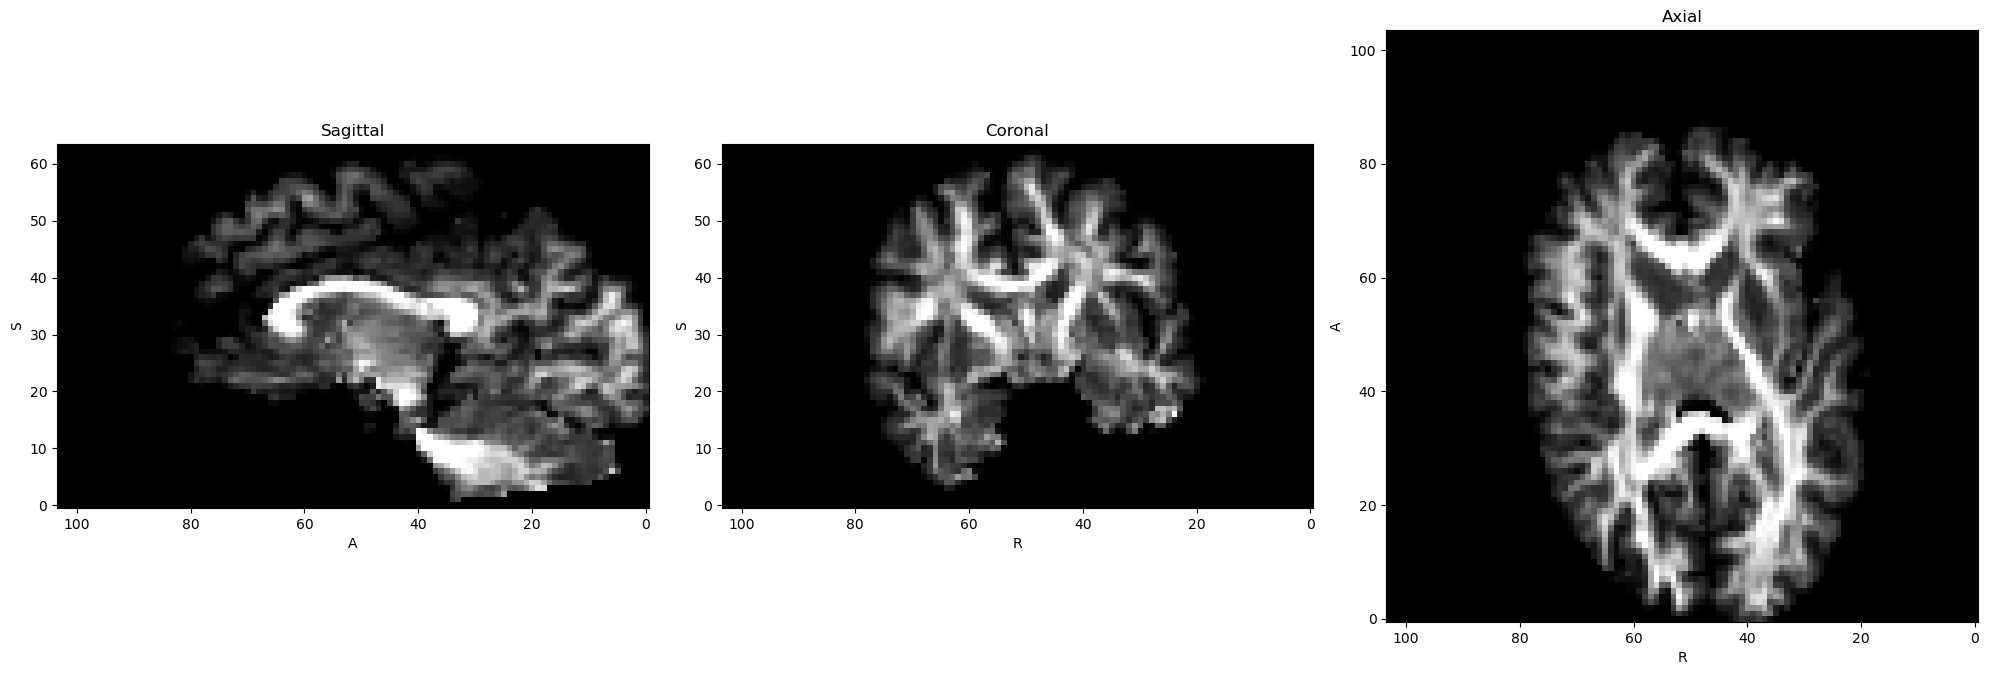

In [353]:
tio.ScalarImage(tensor=a["FA"][tio.DATA][0]).plot(figsize=(20,10))

In [332]:
logit = net(inputs)
proba = torch.nn.Sigmoid()(logit)
losses = torch.nn.BCELoss(reduction="none")(proba, target)
losses

tensor([[0.6099],
        [0.7694],
        [0.6624]], device='cuda:0')

In [335]:
logit = net(inputs)
losses = torch.nn.BCEWithLogitsLoss(reduction="none")(logit, target)
losses

tensor([[0.6099],
        [0.7694],
        [0.6624]], device='cuda:0')